# Machine Learn Classification - Customer Churn (Kaggle - Telco Customer Churn)

This notebook walks around a standard method to building a model based on **Gradient Boosting Classifier** to predict customer churn with data from Kaggle (*https://www.kaggle.com/datasets/blastchar/telco-customer-churn?resource=download*).

Classification methods with unbalanced datasets usually are plagued with **high accuracy** but low **power**. Most of those usually have good results with **Random Forest Trees**, but statistically a **truncated OLS** can get high power according to few papers in literature, so it might also be worth the shot.

The results here show decent power compared to the type 2 erros I am used to in these classification problems (*almost 3/4 of the Churn are predicted*) but *lower accuracy*. Half of the predicted (*Churn = Yes*) are **false-positives**, but from results it is clear that **buying fidelity is the key**.

The goal here is to show a bit of a *Data Science* pipeline, not an *academic, econometrics-based study*. I am usually very worried/curious about inference, so I tend to gravitate to the later option or both.

## About

I am Leonardo Brioschi, a *Ph.D. candidate at Accounting/Finance track*. Please visit **https://leobrioschi.gitlab.io**


In [417]:
import pandas as pd
import numpy as np
import nbformat
import itertools
import pickle
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
import plotly_express as px

In [418]:
def wrangle(filename):
    df = pd.read_csv(filename)
    df.drop(columns=['customerID'],inplace=True)
    df = df[df['TotalCharges'] != ' ']
    df['TotalCharges'] = df['TotalCharges'].astype('float64')
    category = ['gender', 'Partner', 'Dependents', 'PhoneService',
       'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'Contract', 'PaperlessBilling', 'PaymentMethod',
       'Churn']
    df[category] = df[category].astype('category')
    return df

In [419]:
filename = 'WA_Fn-UseC_-Telco-Customer-Churn.csv'
df = wrangle(filename)
df.describe()

SeniorCitizen       tenure  MonthlyCharges  TotalCharges
count    7032.000000  7032.000000     7032.000000   7032.000000
mean        0.162400    32.421786       64.798208   2283.300441
std         0.368844    24.545260       30.085974   2266.771362
min         0.000000     1.000000       18.250000     18.800000
25%         0.000000     9.000000       35.587500    401.450000
50%         0.000000    29.000000       70.350000   1397.475000
75%         0.000000    55.000000       89.862500   3794.737500
max         1.000000    72.000000      118.750000   8684.800000

In [420]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   gender            7032 non-null   category
 1   SeniorCitizen     7032 non-null   int64   
 2   Partner           7032 non-null   category
 3   Dependents        7032 non-null   category
 4   tenure            7032 non-null   int64   
 5   PhoneService      7032 non-null   category
 6   MultipleLines     7032 non-null   category
 7   InternetService   7032 non-null   category
 8   OnlineSecurity    7032 non-null   category
 9   OnlineBackup      7032 non-null   category
 10  DeviceProtection  7032 non-null   category
 11  TechSupport       7032 non-null   category
 12  StreamingTV       7032 non-null   category
 13  StreamingMovies   7032 non-null   category
 14  Contract          7032 non-null   category
 15  PaperlessBilling  7032 non-null   category
 16  PaymentMethod     7032 n

There are **19 columns** besides the target, with only 3 numeric (but one is a dummy for *senior citzens* and the other a discrete value of *dependents*), that is why the **OneHotEncoder** was loaded. Also, **customerID** is not relevant, **tenure** has the relationship's span information, there is no need to break into older and newer customers by ID. 

In [421]:
df.describe(exclude='number')

gender Partner Dependents PhoneService MultipleLines InternetService  \
count    7032    7032       7032         7032          7032            7032   
unique      2       2          2            2             3               3   
top      Male      No         No          Yes            No     Fiber optic   
freq     3549    3639       4933         6352          3385            3096   

       OnlineSecurity OnlineBackup DeviceProtection TechSupport StreamingTV  \
count            7032         7032             7032        7032        7032   
unique              3            3                3           3           3   
top                No           No               No          No          No   
freq             3497         3087             3094        3472        2809   

       StreamingMovies        Contract PaperlessBilling     PaymentMethod  \
count             7032            7032             7032              7032   
unique               3               3                2                 4   
top                 No  Month-to-month              Yes  Electronic check   
freq              2781            3875             4168              2365   

       Churn  
count   7032  
unique     2  
top       No  
freq    5163

From above, seems the data is not too skewed in general, it might be when filtering by **Churn**. More analysis is certainly required. 

In [422]:
print(df['Churn'].value_counts(normalize=True))
df[['Partner','Dependents','PhoneService','MultipleLines','InternetService','OnlineBackup','DeviceProtection']].loc[df['Churn'] == 'Yes'].describe()

No     0.734215
Yes    0.265785
Name: Churn, dtype: float64


Partner Dependents PhoneService MultipleLines InternetService  \
count     1869       1869         1869          1869            1869   
unique       2          2            2             3               3   
top         No         No          Yes           Yes     Fiber optic   
freq      1200       1543         1699           850            1297   

       OnlineBackup DeviceProtection  
count          1869             1869  
unique            3                3  
top              No               No  
freq           1233             1211

Data is a bit imbalanced, the number of users where **Churn == Yes** turns the distribution of the features a bit skewed (*comparing to our prior*). Maybe we could show it in a few graphs. 

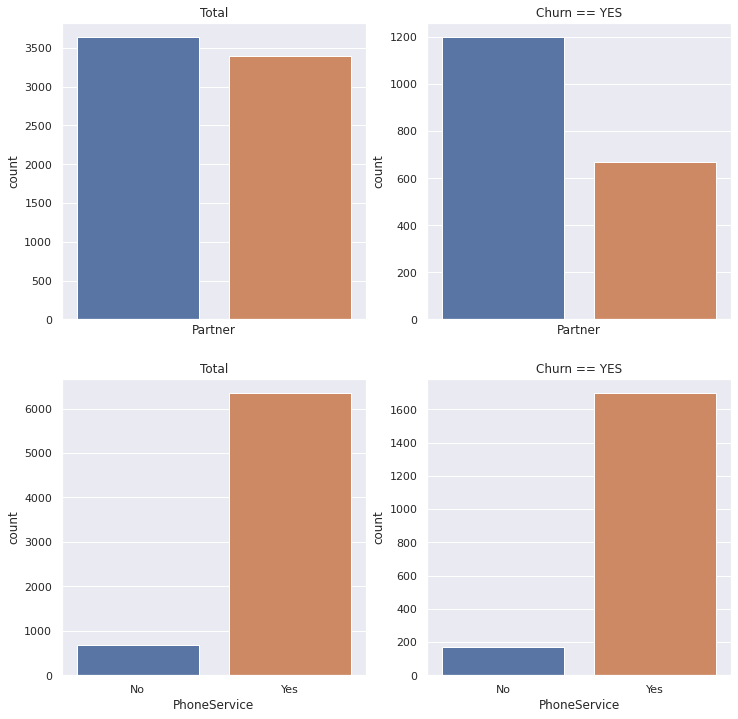

In [423]:
df_churn = df[df['Churn'] == 'Yes']
sns.set_theme(style="darkgrid")

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 12), sharex=True)

view1 =['Partner', 'PhoneService']
axes = [[ax1,ax2],[ax3,ax4]]
# Draw a nested barplot by species and sex
for each in range(0,len(view1)):
    sns.countplot(data=df, x=view1[each], ax=axes[each][0])
    sns.countplot(data=df_churn, x=view1[each], ax=axes[each][1])
    axes[each][0].set_title('Total')
    axes[each][1].set_title('Churn == YES')

plt.savefig("dist-comparison.png", dpi=150)

Just by looking at the two examples above, it easy to see how a subset of the data (**Churn == Yes**) has a wildly different distribution. It is interesting to note that some features have similar distribution.

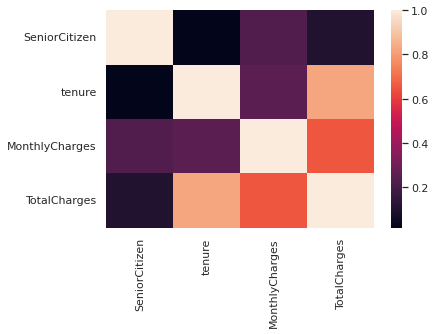

In [424]:
features = list(df.columns)
features.remove('Churn')
corr = df[features].corr()
sns.heatmap(corr)
plt.savefig("correlation-heatmap.png", dpi=150)

Looking at the few numeric features left, seems the correlation is low, no need to check partial correlations. Since I will use a pipeline with OneHotEncoder, **MonthlyCharges** and **Tenure** will be made into categorical : (*very-low*,*low*,*low-med*,*med*,*high-med*,*high*,*very-high*), acording to spending/time. **TotalCharges** will be dropped since it has high correlation with **Tenure**. **Partner** will also be dropped since it describes a lot of the same from **Dependents**.

In [425]:
# Dropping TotalCharges and Partner and removing from features list
df.drop(columns=['TotalCharges','Partner'],inplace=True)
features.remove('TotalCharges')
features.remove('Partner')

# Encoding MonthlyCharges
df['MonthlyCharges'] = pd.qcut(df['MonthlyCharges'],7,labels=['very-low','low','low-med','med','high-med','high','very-high'])
df['tenure'] = pd.qcut(df['tenure'],7,labels=['very-low','low','low-med','med','high-med','high','very-high'])
df['MonthlyCharges'].describe()

count         7032
unique           7
top       very-low
freq          1019
Name: MonthlyCharges, dtype: object

## Creating dataset for model fitting and settings
Now i will just split the dataset randomly (*20% for validation later*), define the range of the hyperparameters for the RGBoosting pipeline and get ready to fit the model.

In [426]:
target = 'Churn'
y = df[target]
X = df[features]

In [427]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (5625, 17)
X_test shape: (1407, 17)


In [428]:
''' Oversampling '''
oversampler = RandomOverSampler(random_state=42)
X_train_ov, y_train_ov = oversampler.fit_resample(X_train,y_train)

## Building the pipeline, fitting the model

In [429]:
pipe = make_pipeline(OneHotEncoder(),GradientBoostingClassifier(max_depth=5))
pipe

Pipeline(steps=[('onehotencoder', OneHotEncoder()),
                ('gradientboostingclassifier',
                 GradientBoostingClassifier(max_depth=5))])

In [430]:
params = {
          "gradientboostingclassifier__max_depth": range(3,6),
          "gradientboostingclassifier__n_estimators": range(17, 36)
         }

In [431]:
''' Grid Search CV(Cross Validation)
    -Will test the range of hyperparameters, doing cross-validation (split the data in 5 randomly and test)
    -> At the end, the best model will be fitted in the whole X_train_ov (default)'''
model = GridSearchCV(pipe, param_grid=params, cv=5,verbose=1,n_jobs=-1)
model.fit(X_train_ov,y_train_ov)

Fitting 5 folds for each of 57 candidates, totalling 285 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('onehotencoder', OneHotEncoder()),
                                       ('gradientboostingclassifier',
                                        GradientBoostingClassifier(max_depth=5))]),
             n_jobs=-1,
             param_grid={'gradientboostingclassifier__max_depth': range(3, 6),
                         'gradientboostingclassifier__n_estimators': range(17, 36)},
             verbose=1)

In [432]:
''' Getting all the results from the Grid Search '''
results = pd.DataFrame(model.cv_results_)
results.head(5)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.670222      0.130038         0.058333        0.015074   
1       0.736158      0.108030         0.057022        0.012466   
2       0.697242      0.115683         0.047423        0.008750   
3       0.763950      0.107733         0.050718        0.004473   
4       0.813524      0.104704         0.042944        0.009195   

  param_gradientboostingclassifier__max_depth  \
0                                           3   
1                                           3   
2                                           3   
3                                           3   
4                                           3   

  param_gradientboostingclassifier__n_estimators  \
0                                             17   
1                                             18   
2                                             19   
3                                             20   
4                                             21   

                                              params  split0_test_score  \
0  {'gradientboostingclassifier__max_depth': 3, '...           0.756053   
1  {'gradientboostingclassifier__max_depth': 3, '...           0.754843   
2  {'gradientboostingclassifier__max_depth': 3, '...           0.754237   
3  {'gradientboostingclassifier__max_depth': 3, '...           0.753027   
4  {'gradientboostingclassifier__max_depth': 3, '...           0.752421   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
0           0.772397           0.749395           0.766344           0.765738   
1           0.777845           0.748789           0.765133           0.774213   
2           0.781477           0.749395           0.771186           0.773608   
3           0.780266           0.750000           0.770581           0.771186   
4           0.782688           0.752421           0.771186           0.772397   

   mean_test_score  std_test_score  rank_test_score  
0         0.761985        0.008188               57  
1         0.764165        0.011067               56  
2         0.765981        0.012152               54  
3         0.765012        0.011583               55  
4         0.766223        0.011957               53

In [433]:
best_params = results.iloc[model.best_index_,:]['params']
print(best_params)

{'gradientboostingclassifier__max_depth': 5, 'gradientboostingclassifier__n_estimators': 35}


It seems that the *Gradient Boosting Classifier* is getting better results for each time I up the *max_depth* but due to overfitting I had to stop at **5**. The **# of estimators** are around *30-33* in all passes from depth *3-7*. I won't go further on this rabbit hole before parsing the validation results.

## Checking results
Since we have a problem due to being somewhat easy to take a guess with classification problems and still getting good accuracy, we will check the *confusion matrix*, nothing more than the good old statistics **Real**(True or false) versus **Predicted**

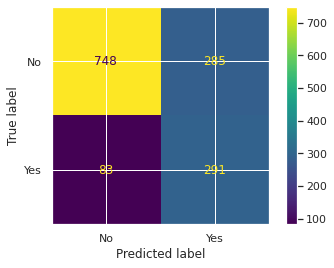

<Figure size 432x288 with 0 Axes>

In [434]:
cm = confusion_matrix(y_test, model.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()
plt.savefig("kaggle-churn-cm.png", dpi=150)

From the *Confusion Matrix* we are getting about **75%** of the *Churn* right (*291/(291+91)*), so the model's *power* is good, but gets a lot of false-positives. Depending on the cost of interacting with those *costumers* it is acceptable. Now the "campaign" should hit most of these people, and instead of wasting time on all the *costumers* the model cuts the target to **40.9%**. 

In [435]:
''' The good old stats table  '''
class_report = classification_report(y_test, model.predict(X_test))
print(class_report)

              precision    recall  f1-score   support

          No       0.90      0.72      0.80      1033
         Yes       0.51      0.78      0.61       374

    accuracy                           0.74      1407
   macro avg       0.70      0.75      0.71      1407
weighted avg       0.80      0.74      0.75      1407



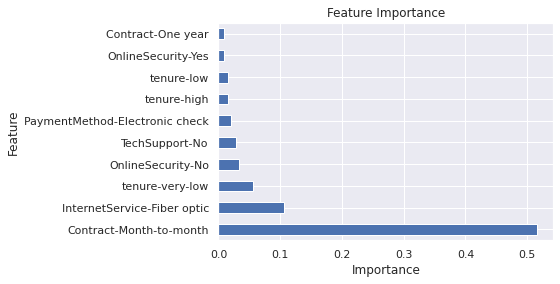

In [436]:
''' Extracting the feature importances and category names '''

# Extract importances
importances = model.best_estimator_.named_steps['gradientboostingclassifier'].feature_importances_

# Create the index of encoded features
names_feat =  model.best_estimator_.named_steps['onehotencoder'].feature_names_in_
names_cat =  model.best_estimator_.named_steps['onehotencoder'].categories_
full_names = list()
for count,value in enumerate(names_feat):
    for each in names_cat[count]:
        full_names.append(f'{value}-{each}')

# Create a series
feat_imp = pd.Series(importances, index=full_names).sort_values(ascending=False)

# Plot 10 most important features
feat_imp.head(10).plot.barh()
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance");
plt.savefig("kaggle-churn-feature-imp.png", dpi=150)


Mapping the **OneHotEncoder** categories is a bit troublesome, but at first glance is easy to see that the **Month-to-month** contract is really the biggest factor here. Also the **Fiber optic** costumers and new (*Tenure = very low*) might be good candidates.

In [437]:
acc_train = accuracy_score(y_train,model.predict(X_train))
acc_test = accuracy_score(y_test,model.predict(X_test))

print("Training Accuracy:", round(acc_train, 4), "-------","Test Accuracy:", round(acc_test, 4))

Training Accuracy: 0.781 ------- Test Accuracy: 0.7385


## Saving the model
Finally this is the part were we save the model, we can either save the whole **Grid Search-Cross Validation** results or just the best model, it doesn't matter, when asked to predict *sklearn* will use the best one.

In [438]:
pickle.dump(model,open("kaggle-telco-churn.pkl", "wb"))

Thank you! Please visit https://leobrioschi.gitlab.io.